### Семинар 4. Seq2seq

В этом семинаре мы будем учить рекуррентную модель машинного перевода. Работать будем с описаниями отелей на русском и английском языке.

![img](https://esciencegroup.files.wordpress.com/2016/03/seq2seq.jpg)

Для скачивания данных запустите код ниже.

In [1]:
# ! wget https://www.dropbox.com/scl/fi/inwn1t0gnfouagavt289d/en_texts.txt?rlkey=0obl4plaeqhtd5j7msnfb3vwz&dl=1 -O en_texts.txt
# ! wget https://www.dropbox.com/scl/fi/7ifao8ei5d2fkbnvidwqs/ru_texts.txt?rlkey=v8r5jf7ep7rethmwf71n6qoke&dl=1 -O ru_texts.txt

### Токенизация

Токенизировать наш текст будем с помощью BPE. Все необходимые функции для обучения своего токенизатора можно импортировать из библиотеки `huggingface`. Заметьте, что нам понадобится два токенизатора: для английского и русского языков. Конечно, можно обучить один для всего, но, так как английский текст никогда не пересекается с русским, в этом нет смысла (мы только ухудшим качество токенов).

In [2]:
from tokenizers import Tokenizer, processors
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from transformers import PreTrainedTokenizerFast, PreTrainedTokenizer, BertTokenizer, BertTokenizerFast, GPT2TokenizerFast

In [3]:
def train_tokenizer(files):
    unk_token = '[UNK]'  # token for unknown words
    spl_tokens = ['[UNK]', '[SEP]', '[CLS]', '[PAD]']  # special tokens

    tokenizer = Tokenizer(BPE(unk_token=unk_token))
    trainer = BpeTrainer(special_tokens=spl_tokens, vocab_size=30000)

    tokenizer.pre_tokenizer = Whitespace()
    tokenizer.train(files, trainer)

    bos_token_id = tokenizer.token_to_id('[CLS]')
    eos_token_id = tokenizer.token_to_id('[SEP]')
    unk_token_id = tokenizer.token_to_id('[UNK]')
    pad_token_id = tokenizer.token_to_id('[PAD]')
    
    tokenizer.post_processor = processors.TemplateProcessing(
        single=f"[CLS]:0 $A:0 [SEP]:0",
        pair=f"[CLS]:0 $A:0 [SEP]:0 $B:1 [SEP]:1",
        special_tokens=[("[CLS]", bos_token_id), ("[SEP]", eos_token_id)],
    )

    tokenizer = PreTrainedTokenizerFast(
        tokenizer_object=tokenizer,
        bos_token='[CLS]',
        eos_token='[SEP]',
        unk_token='[UNK]',
        pad_token='[PAD]'
    )
    return tokenizer

In [4]:
en_tokenizer = train_tokenizer(['en_texts.txt'])
ru_tokenizer = train_tokenizer(['ru_texts.txt'])

### Датасет

Тут ничего сильно интересного. Читаем наши тексты, делим на тренировочную и тестовую выборки, а затем кладем все в `DataLoader` для дальнейшего удобства.

In [5]:
with open('en_texts.txt') as f:
    en_texts = f.read().strip().split('\n')

with open('ru_texts.txt') as f:
    ru_texts = f.read().strip().split('\n')

texts = list(zip(en_texts, ru_texts))

In [6]:
from sklearn.model_selection import train_test_split

train_texts, test_texts = train_test_split(texts, test_size=0.05)

In [7]:
from torch.utils.data import DataLoader

batch_size = 128

train_loader = DataLoader(train_texts, batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_texts, batch_size=batch_size, shuffle=False, pin_memory=True)

In [8]:
ru_texts[:5]

['Отель Cordelia расположен в Тбилиси, в 3 минутах ходьбы от Свято-Троицкого собора.',
 'В числе удобств лоджа Tupirmarka круглосуточная стойка регистрации и снэк-бар. Гости могут воспользоваться услугой доставки еды и напитков в номер.',
 'Апартаменты Naigao Xiaowo расположены в городе Шанхай. К услугам гостей бесплатный Wi-Fi во всех зонах.',
 'В вашем распоряжении также телевизор и собственная ванная комната с душем.',
 'Номер оснащен кондиционером и спутниковым телевидением.']

In [13]:
tokenized = ru_tokenizer(ru_texts[:5], padding=True, return_tensors='pt')

In [14]:
print(tokenized['input_ids'])

tensor([[    2,   462,  2746,  2309,   888,   357,   204,  3674,    15,   204,
            22,   413,   551,   256, 21425,    16, 15565,   632,  1941,    17,
             1,     3,     3,     3,     3,     3,     3,     3,     3],
        [    2,   175,   528,   533,  4924, 24480,  1230,  6935,  2537,  1178,
          1139,   688,   210,  2793,    16,   527,    17,   519,   418,   796,
          4930,  3201,  1609,   210,  1398,   204,  1168,    17,     1],
        [    2,   573,  4565,  1487,  8562, 16473, 17518,   706,   204,   637,
         18295,    17,   183,   380,   329,   410,   378,    16,   379,   289,
           749,  1698,    17,     1,     3,     3,     3,     3,     3],
        [    2,   175,  1171,   525,   459,   539,   210,   630,   475,   506,
           219,   613,    17,     1,     3,     3,     3,     3,     3,     3,
             3,     3,     3,     3,     3,     3,     3,     3,     3],
        [    2,  7590,  1511,   624,   210,  1890,  1342,    17,     1,     

In [15]:
print(tokenized['attention_mask'])

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
         0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0]])


### Encoder-decoder model

Ниже написан код для модели, которую нам предстоит обучать. В качестве и энкодера, и декодера мы берем базовую однослойную версию GRU. При желании вы можете усложнить модель (учеличить размер, добавить механизм внимания и тд) и посмотреть, улучшает ли это результат.

In [21]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [22]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, hidden_size=128):
        super().__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(vocab_size, hidden_size)

        self.gru = nn.GRU(input_size=hidden_size, hidden_size=hidden_size, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, hidden_size)
    
    def forward(self, x, attention_mask):
        embed = self.embedding(x)

        output, h = self.gru(embed)

        # take output of the last token
        lens = attention_mask.sum(1)  # [bs]
        idx = (lens - 1).unsqueeze(1).expand(output.size(0), output.size(2)).unsqueeze(1)
        # [bs, 1, d]

        # [bs, seq_len, d]
        output = output.gather(1, idx.to(device)).squeeze()

        # [1, bs, d]
        return self.fc(output).unsqueeze(0)


class Decoder(nn.Module):
    def __init__(self, vocab_size, hidden_size=128):
        super().__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, hidden_size)

        self.gru = nn.GRU(input_size=hidden_size, hidden_size=hidden_size, batch_first=True)

        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, init_state):
        embed = self.embedding(x)

        output, h = self.gru(embed, init_state)

        output = self.fc(output)

        return output, h

class Model(nn.Module):
    def __init__(self, in_vocab_size, out_vocab_size, hidden_size=128):
        super().__init__()
        self.encoder = Encoder(in_vocab_size, hidden_size)
        self.decoder = Decoder(out_vocab_size, hidden_size)

    def forward(self, input_ids, output_ids, attention_mask):
        encoded = self.encoder(input_ids, attention_mask)
        logits, _ = self.decoder(output_ids, encoded)
        return logits


def clear_text(texts):
    clear_texts = []
    for text in texts:
        text = text.replace('[PAD]', '')
        cls_pos = text.find('[CLS]')
        if cls_pos > -1:
            text = text[cls_pos + len('[CLS]'):]

        sep_pos = text.find('[SEP]')
        if sep_pos > -1:
            text = text[:sep_pos]

        clear_texts.append(text.strip())

    return clear_texts


@torch.no_grad()
def translate(model, texts):
    model.eval()

    en_tokenized = en_tokenizer(texts, padding=True, return_tensors='pt')
    input_ids = en_tokenized['input_ids'].to(device)
    attention_mask = en_tokenized['attention_mask'].to(device)
    state = model.encoder(input_ids, attention_mask)

    cur_tokens = torch.full((len(texts), 1), ru_tokenizer.bos_token_id, device=device)
    output_ids = cur_tokens.clone()

    ended_texts = torch.zeros(len(texts))
    for i in range(256):
        logits, state = model.decoder(cur_tokens, state)

        next_tokens = logits.argmax(-1)

        cur_tokens = next_tokens
        output_ids = torch.cat((output_ids, cur_tokens), dim=1)
        
        ended_texts += (next_tokens.cpu().squeeze(1) == ru_tokenizer.eos_token_id)
        if torch.all(ended_texts > 0):
            break

    return ru_tokenizer.batch_decode(output_ids)

### Функция ошибки

Тут все почти так же, как для языковых моделей, за исключение обуславливания на входную последовательность
$$ L = -{\frac1{|D|}} \sum_{X, Y \in D} \sum_{y_t \in Y} \log p(y_t \mid y_1, \dots, y_{t-1}, X, \theta) $$

### Оценка качества: BLEU

Страндартно качество модели для машинного перевода оценивается с помощью [BLEU](https://en.wikipedia.org/wiki/BLEU). Она считает долю 1,2,3,4-грамм  переведенных текстов, которые содержатся в целевых, и находит их геометрическое среднее. Помимо этого добавляется штраф, если переведенный текст короче целевого.

<!-- While BLEU [has many drawbacks](http://www.cs.jhu.edu/~ccb/publications/re-evaluating-the-role-of-bleu-in-mt-research.pdf), it still remains the most commonly used metric and one of the simplest to compute. -->

In [24]:
from nltk.translate.bleu_score import corpus_bleu

@torch.no_grad()
def compute_bleu(model, translated_text, target_text):
    """
    Estimates corpora-level BLEU score of model's translations given inp and reference out
    """

    return corpus_bleu(
        [[ref.split()] for ref in target_text],
        [trans.split() for trans in translated_text],
        smoothing_function=lambda precisions, **kw: [p + 1.0 / p.denominator for p in precisions]
    ) * 100

### Обучение

In [25]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
from tqdm.auto import tqdm, trange

model = Model(len(en_tokenizer), len(ru_tokenizer), hidden_size=256).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [30]:
accuracies = []
metrics = {'train_acc': [], 'train_loss': [], 'test_loss': [], 'test_bleu': []}

def train(model, dataloader, optimizer):
    model.train()
    
    criterion = nn.CrossEntropyLoss(ignore_index=ru_tokenizer.pad_token_id)

    for texts in tqdm(dataloader):
        en_texts, ru_texts = texts

        en_tokenized = en_tokenizer(en_texts, padding=True, return_tensors='pt')
        input_ids = en_tokenized['input_ids'].to(device)
        attention_mask = en_tokenized['attention_mask'].to(device)

        ru_tokenized = ru_tokenizer(ru_texts, padding=True, return_tensors='pt')
        output_ids = ru_tokenized['input_ids'].to(device)

        logits = model(input_ids, output_ids, attention_mask)

        shift_logits = logits[:, :-1].contiguous()
        shift_outputs = output_ids[:, 1:].contiguous()

        loss = criterion(shift_logits.view(-1, shift_logits.size(-1)), shift_outputs.view(-1))

        accuracy = (shift_logits.argmax(-1).view(-1) == shift_outputs.view(-1)).float()
        accuracy = accuracy[shift_outputs.view(-1) != ru_tokenizer.pad_token_id].mean()

        metrics['train_acc'].append(accuracy.item())
        metrics['train_loss'].append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        clear_output(wait=True)
        plt.figure(figsize=(15, 4))
        for i, (k, v) in enumerate(metrics.items()):
            plt.subplot(1, len(metrics), i + 1)
            plt.plot(v)
            plt.grid()
            plt.title(k, fontsize=16)

        plt.show()
        
def evaluate(model, dataloader):
    model.eval()
    criterion = nn.CrossEntropyLoss(ignore_index=ru_tokenizer.pad_token_id)
    
    translated_text = []
    target_text = []
    losses = []
    for texts in tqdm(dataloader):
        en_texts, ru_texts = texts
        
        en_tokenized = en_tokenizer(en_texts, padding=True, return_tensors='pt')
        input_ids = en_tokenized['input_ids'].to(device)
        attention_mask = en_tokenized['attention_mask'].to(device)
        
        ru_tokenized = ru_tokenizer(ru_texts, padding=True, return_tensors='pt')
        output_ids = ru_tokenized['input_ids'].to(device)

        logits = model(input_ids, output_ids, attention_mask)

        shift_logits = logits[:, :-1].contiguous()
        shift_outputs = output_ids[:, 1:].contiguous()
        
        loss = criterion(shift_logits.view(-1, shift_logits.size(-1)), shift_outputs.view(-1))
        losses.append(loss.item())
        
        translations = clear_text(translate(model, en_texts))
    
        translated_text.extend(translations)
        target_text.extend(ru_texts)

    return {
        'bleu': compute_bleu(model, translated_text, target_text),
        'loss': np.mean(losses)
    }

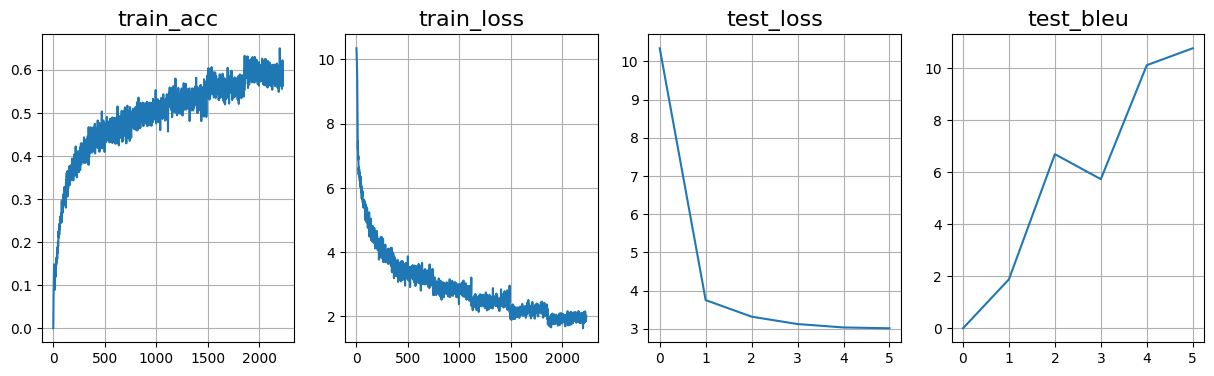

  0%|          | 0/20 [00:00<?, ?it/s]

In [19]:
for e in range(6):
    train(model, train_loader, optimizer)

    result = evaluate(model, test_loader)
    metrics['test_bleu'].append(result['bleu'])
    metrics['test_loss'].append(result['loss'])

In [21]:
torch.save(model.state_dict(), 'model.pt')

In [28]:
model.load_state_dict(torch.load('model.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

In [31]:
evaluate(model, test_loader)

  0%|          | 0/20 [00:00<?, ?it/s]

{'bleu': 13.800212051678166, 'loss': 1.7270925164222717}

In [33]:
en_texts, ru_texts = next(iter(test_loader))

In [34]:
translations = translate(model, en_texts)
clear_text(translations[:10])

['Поездка от отеля типа « постель и завтрак » до города Лечче занимает 15 минут, а до аэропорта Хусейн Састранегара можно доехать за 20 минут.',
 'В апартаментах имеется собственный балкон и полностью оборудованная кухня с посудомоечной машиной.',
 'Поездка до международного аэропорта Лиссабона Портела займет 25 минут.',
 'В числе удобств терраса с видом на море.',
 'Апартаменты располагают гостиной с диваном - кроватью и телевизором с плоским экраном и спутниковыми каналами, а также гостиной с диваном - кроватью.',
 'В кафе - баре отеля подают блюда местной и интернациональной кухни.',
 'Расстояние от отеля до музея Пасифи музея и парка аттракционов « Всемирный центр » составляет 1, 5 км.',
 'Расстояние до станции метро « Площадь Восстания » составляет 2 км.',
 'В экскурсионном бюро можно организовать поездки.',
 'Апартаменты Ive And rica с кондиционером, бесплатным Wi - Fi и частная парковка на территории расположены в городе Санта - Маргерита - Лигуре.']

In [38]:
for en, ru, tr in zip(en_texts[:10], ru_texts[:10], clear_text(translations[:10])):
    print(en)
    print(ru)
    print(tr)
    print()

Surfside Vanuatu is 15 minutes’ drive from Port Vila and 20 minutes’ drive from Bauerfield International Airport.
Комплекс Surfside Vanuatu находится в 15 минутах езды от города Порт-Вила и в 20 минутах езды от международного аэропорта Бауерфилд.
Поездка от отеля типа « постель и завтрак » до города Лечче занимает 15 минут, а до аэропорта Хусейн Састранегара можно доехать за 20 минут.

Casa Artgo includes a balcony and patio with a washing machine.
К услугам гостей дома для отпуска Casa Artgo балкон, патио и стиральная машина.
В апартаментах имеется собственный балкон и полностью оборудованная кухня с посудомоечной машиной.

It takes 25 minutes to drive to Irkutsk Airport.
До аэропорта Иркутска 25 минут езды на автомобиле.
Поездка до международного аэропорта Лиссабона Портела займет 25 минут.

A terrace with outdoor fireplace is at guests’ disposal.
К услугам гостей терраса с камином на открытом воздухе.
В числе удобств терраса с видом на море.

Heated apartments feature a living room 